In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
#Read csv into a dataframe
df = pd.read_csv("ThreePointOctNov.csv", header = 0)

In [4]:
#Extract the labels and clean the inputs of player name.
Y = df["three_pct_season"]
X = df.drop(columns=["three_pct_season", "Name"])

In [9]:
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=12))])
X = pipeline.fit_transform(X)

In [10]:
"""
Here I'm just separating the dataset into training and test subsets. 
I fixed the random_state to an integer so the split would be reproducible
"""
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25, random_state = 12) 

In [11]:
#run principal components analysis
pca = PCA(n_components = 12)
pca.fit(X_train)

PCA(n_components=12)

In [12]:
#Seems like x_1 through x_5 are sufficient to explain the bulk of the variance, so I'll rely on those
print(pca.explained_variance_ratio_)

[0.24187941 0.15150544 0.12677055 0.10152347 0.08626369 0.07855262
 0.06162184 0.05126339 0.04347322 0.02621071 0.01743165 0.01350402]


In [8]:
#Isolate x_1 through x_5 in training set
X_train.drop(columns=['ft_pct_oct_nov',
       'lwr_paint_shots_oct_nov', 'upr_paint_shots_oct_nov',
       'mid_shots_oct_nov', 'three_non_cnr_shots_oct_nov',
       'three_cnr_shots_oct_nov', 'ft_shots_oct_nov'], inplace=True)

In [9]:
#Isolate x_1 through x_5 in test set
X_test.drop(columns=['ft_pct_oct_nov',
       'lwr_paint_shots_oct_nov', 'upr_paint_shots_oct_nov',
       'mid_shots_oct_nov', 'three_non_cnr_shots_oct_nov',
       'three_cnr_shots_oct_nov', 'ft_shots_oct_nov'], inplace=True)

In [10]:
#Linear regression - gives an R squared of .992!
OLS_model = sm.OLS(Y_train, X_train, hasconst=None)
OLS_results = OLS_model.fit()
OLS_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       three_pct_season   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              1909.
Date:                Sat, 02 Dec 2023   Prob (F-statistic):                    2.33e-78
Time:                        19:35:37   Log-Likelihood:                          163.99
No. Observations:                  81   AIC:                                     -318.0
Df Residuals:                      76   BIC:                                     -306.0
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
lwr_paint_pct_oct_nov         0.1006      0.034      2.971      0.004       0.033       0.168
upr_paint_pct_oct_nov         0.1079      0.041      2.637      0.010       0.026       0.189
mid_pct_oct_nov               0.0887      0.030      2.980      0.004       0.029       0.148
three_non_cnr_pct_oct_nov     0.2291      0.036      6.406      0.000       0.158       0.300
three_cnr_pct_oct_nov         0.3709      0.047      7.890      0.000       0.277       0.464
==============================================================================
Omnibus:                       18.745   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.890
Skew:                          -0.899   Prob(JB):                     1.96e-07
Kurtosis:                       5.433   Cond. No.                         13.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
#Determine coefficients for weighted linear regression
Y_resid = [abs(resid) for resid in OLS_results.resid]
X_resid = OLS_results.fittedvalues

res_residuals_OLS_model = sm.OLS(Y_resid, X_resid, hasconst=None).fit()
mod_fv = res_residuals_OLS_model.fittedvalues
weights = 1 / (mod_fv**2)

In [12]:
"""
Build the weighted least squares linear regression model.
"""
WLS_model = sm.WLS(Y_train, X_train, hasconst=None, weights=weights)
WLS_results = WLS_model.fit()
print(WLS_results.summary())


                                 WLS Regression Results                                
Dep. Variable:       three_pct_season   R-squared (uncentered):                   0.992
Model:                            WLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              1847.
Date:                Sat, 02 Dec 2023   Prob (F-statistic):                    8.11e-78
Time:                        19:35:37   Log-Likelihood:                          163.00
No. Observations:                  81   AIC:                                     -316.0
Df Residuals:                      76   BIC:                                     -304.0
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [13]:
"""
Next, get cross validation score of random forest model. Used default k=5 fold cross val. 
Loss function is MSE (don't need to specify it in params - it is the default)
Set random_state to 0 for reproducibility.
Use GridSearchCV to find optimal depth of trees
"""

random_forest = GridSearchCV(RandomForestRegressor(random_state=0), {'max_depth': range(1, 10)})
random_forest.fit(X_train, Y_train)
print(np.mean([np.absolute(x) for x in cross_val_score(random_forest, X_train, Y_train)]))

0.31654778596847555


In [14]:
"""
Note: I'm taking the averages of the absolute values of the cross validation scores because scikit 
returns negative numbers for MSE on some folds.
The negative values are not an issue - this is still MSE, it's just a quirk in how scikit works. The absolute value is the true MSE.
This average isn't great, so let's try gradient boosting.
"""


"\nNote: I'm taking the averages of the absolute values of the cross validation scores because scikit \nreturns negative numbers for MSE on some folds.\nThe negative values are not an issue - this is still MSE, it's just a quirk in how scikit works. The absolute value is the true MSE.\nThis average isn't great, so let's try gradient boosting.\n"

In [15]:
"""
Finally, fit a boosted decision tree model. 
Set random_state to 0 for reproducibility. 
Use GridSearchCV for learning rate and max depth.
"""
gradient_boosting = GridSearchCV(GradientBoostingRegressor(random_state=0), {'learning_rate': [.00001, .0001, .001, .01, .1], 'max_depth': range(1, 10)}) 
gradient_boosting.fit(X_train, Y_train)
print(np.mean([np.absolute(x) for x in cross_val_score(gradient_boosting, X_train, Y_train)]))

0.34486504796262607


In [16]:
"""
The cross validation scores for both random forest and gradient boosting aren't great
This suggests that those models are a bit too complex for the data.
Linear regression therefore is probably better. Let's then look at the MSE for the two linear models 
on the training set. 
"""

"\nThe cross validation scores for both random forest and gradient boosting aren't great\nThis suggests that those models are a bit too complex for the data.\nLinear regression therefore is probably better. Let's then look at the MSE for the two linear models \non the training set. \n"

In [17]:
#Let's see the MSE of the unweighted linear model on the training set.
Y_pred = OLS_results.predict(X_train)
print(mean_squared_error(Y_train, Y_pred))

0.0010209631341279919


In [18]:
#That's a good mean squared error! Now let's move onto the weighted linear model

In [19]:
Y_pred = WLS_results.predict(X_train)
print(mean_squared_error(Y_train, Y_pred))

0.0010272049176621504


In [20]:
"""
That's great as well. So now we need a way to decide between 
unweighted and weighted linear regression. 

Let's look at whether there is evidence of heteroskedasticity.
"""

"\nThat's great as well. So now we need a way to decide between \nunweighted and weighted linear regression. \n\nLet's look at whether there is evidence of heteroskedasticity.\n"

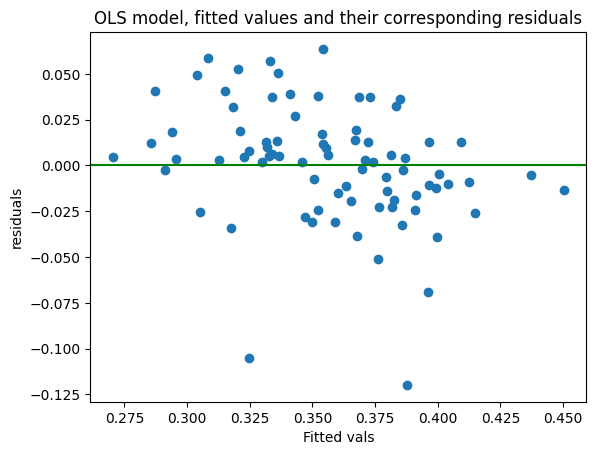

In [21]:
#Plot of the OLS residuals vs fitted values
plt.scatter(OLS_results.fittedvalues, OLS_results.resid)
plt.title("OLS model, fitted values and their corresponding residuals")
plt.xlabel("Fitted vals")
plt.ylabel("residuals")
plt.axhline(y=0, color='g')
plt.show()

In [22]:
"""
It appears like there might be a cone shape developing, so we might
want to be safe and not assume homoscedasticity. Therefore, the weighted linear
regression is probably the model we want to go with.

Let's see the mean squared error of the weighted linear model on the test set. 
"""

"\nIt appears like there might be a cone shape developing, so we might\nwant to be safe and not assume homoscedasticity. Therefore, the weighted linear\nregression is probably the model we want to go with.\n\nLet's see the mean squared error of the weighted linear model on the test set. \n"

In [23]:
Y_pred = WLS_results.predict(X_test)
print(mean_squared_error(Y_test, Y_pred))

0.0011306691864877859


In [24]:
"""
There we go! The mean squared error is .001, which is certainly acceptable. 
Below is a histogram showing the distribution of the residuals on the test set.
"""

'\nThere we go! The mean squared error is .001, which is certainly acceptable. \nBelow is a histogram showing the distribution of the residuals on the test set.\n'

/var/folders/wt/9_6pdt8n2kz5f1cv6bqysq440000gn/T/ipykernel_21820/3943721192.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=10)


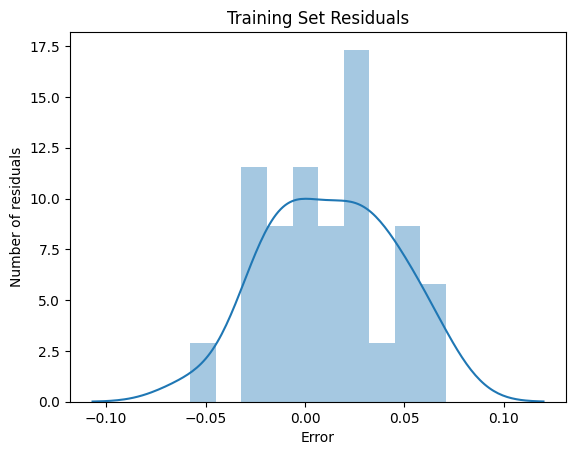

In [25]:
Y_pred_list = Y_pred.tolist()
Y_test_list = Y_test.tolist()

residuals = [(Y_test_list[i] - Y_pred_list[i]) for i in range(len(Y_pred_list))]
sns.distplot(residuals, bins=10)
plt.title("Training Set Residuals")
plt.xlabel("Error")
plt.ylabel("Number of residuals")
plt.show()